In [ ]:
!pip install tradermade

In [ ]:
import math
import pandas_datareader as web
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime
import tradermade as tm
plt.style.use("fivethirtyeight")

In [ ]:
from google.colab import userdata

In [ ]:
API_key = userdata.get("API_key")
tm.set_rest_api_key(API_key)

In [ ]:
# Create a Ticker object for the stock you want to fetch data for
ticker_symbol = "XAUUSD"  # Replace with the symbol of the stock you want
ticker = yf.Ticker(ticker_symbol)

# Fetch historical data for a specific date range
diff = datetime.timedelta(days=7)
start_date = datetime.date.today()-diff
df = ticker.history(interval="30m", start=start_date, end=None)
# mask = ((df.index.time>= datetime.time(1, 0)) & (df.index.time<=datetime.time(4, 0)))
# df = df[mask]
df.shape

ERROR:yfinance:XAUUSD: No timezone found, symbol may be delisted


(0, 6)

In [ ]:
# Create a Ticker object for the stock you want to fetch data for
ticker_symbol = "XAUUSD"  # Replace with the symbol of the stock you want
ticker = yf.Ticker(ticker_symbol)

# Fetch historical data for a specific date range
diff = datetime.timedelta(days=7)
start_date = datetime.date.today() - diff
end_date = datetime.date.today()  # or specify your desired end date

# Use the period parameter to specify the time range
df = ticker.history(start=start_date, end=end_date)

# Print the shape of the DataFrame
print(df.shape)

ERROR:yfinance:XAUUSD: No timezone found, symbol may be delisted


(0, 6)


In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-01-22 09:30:00-05:00,15.420,15.55,15.33,15.5100,1953622,0.0,0.0
2024-01-22 10:00:00-05:00,15.500,15.59,15.48,15.5350,1099539,0.0,0.0
2024-01-22 10:30:00-05:00,15.530,15.54,15.45,15.4695,921970,0.0,0.0
2024-01-22 11:00:00-05:00,15.465,15.53,15.42,15.5150,867271,0.0,0.0
2024-01-22 11:30:00-05:00,15.515,15.56,15.49,15.5600,552035,0.0,0.0


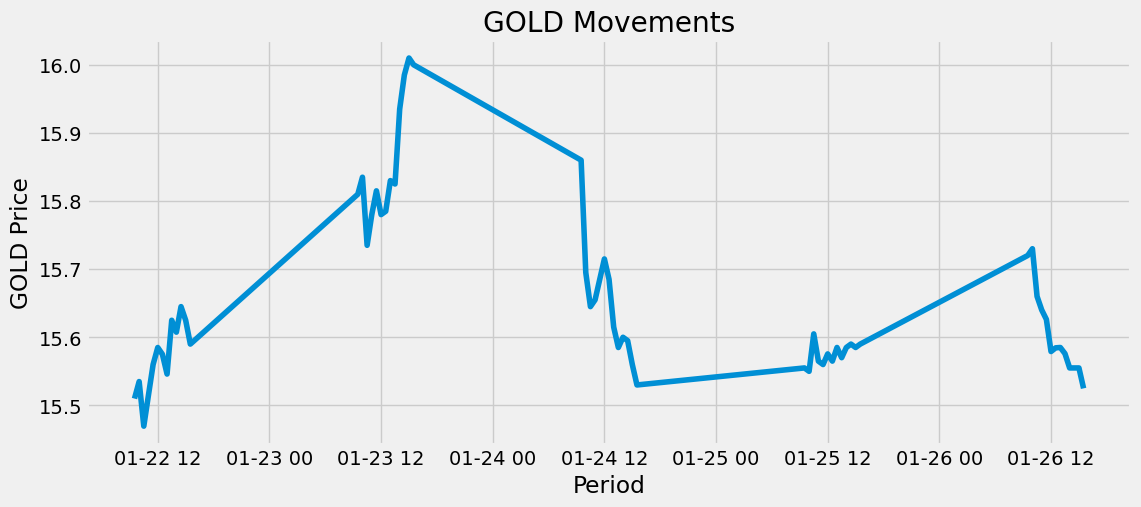

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label=f'Closing {ticker_symbol[:6]} Movement')
plt.xlabel("Period")
plt.ylabel(f"{ticker_symbol[:6]} Price")
plt.title(f"{ticker_symbol[:6]} Movements");

In [ ]:
data = df.filter(['Close'])
data_2 = df.filter(['Close']).values
train_len = math.ceil(len(data_2)*0.8)

In [ ]:
#Scale the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

In [ ]:
#Training Data
train_data = scaled_data[:train_len]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=60:
    print(x_train)
    print(y_train)


In [ ]:
#convert the x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape training data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(181, 60, 1)

In [ ]:
#Build Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

181/181 [==============================] - 9s 33ms/step - loss: 0.0112


In [ ]:
#create the testing data
test_data = scaled_data[train_len-60: , :]
#create x_test and y_test
x_test = []
y_test = data_2[train_len:, : ]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
#Convert test data to numpy arrays and reshape
x_test = np.array(x_test)
bx_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
#model predictions
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

2/2 [==============================] - 1s 18ms/step


In [ ]:
#RSME
rsme = np.sqrt(np.mean(predict-y_test)**2)
rsme

0.5995770772298177

<ipython-input-123-bd4aaeb751e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predict


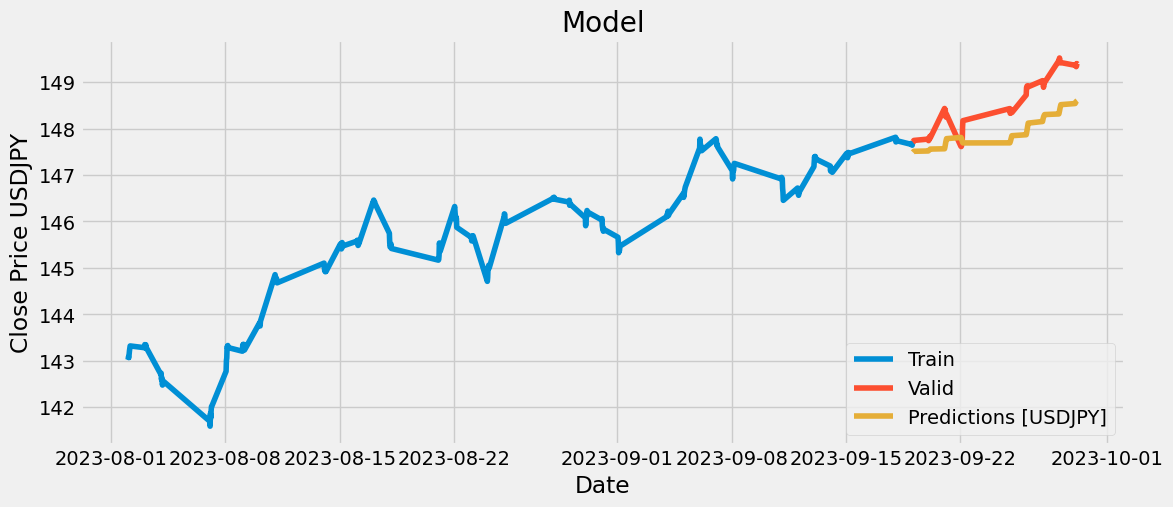

In [ ]:
#plot the data
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predict
#visualize the data
plt.figure(figsize=(12, 5))
plt.title('Model')
plt.ylabel(f"Close Price {ticker_symbol[:6]}")
plt.xlabel("Date")
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', f'Predictions [{ticker_symbol[:6]}]'], loc='lower right');

In [ ]:
!jupyter nbconvert --to pdf LSTM.ipynb
#!jupyter nbconvert --to pdf --PDFExporter.latex_command=pdflatex LSTM.ipynb


[NbConvertApp] Converting notebook LSTM.ipynb to pdf
[NbConvertApp] Support files will be in LSTM_files/
[NbConvertApp] Making directory ./LSTM_files
[NbConvertApp] Writing 37090 bytes to notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 280, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, 